# LAB: Regresión Logística: Haciendo predicciones sobre datos de cáncer de mama

## 1. Introducción

Este dataset sobre cáncer de mama se obtuvo del Hospital de la Universidad de Wisconsin. Son datos producidos por el Dr. William Wolberg en la década del '90. Contiene información de estudios clínicos y celulares. El objetivo es predecir el carácter benigno ($class_t=0$) maligno ($class_t=1$) del cáncer en función de una serie de predictores a nivel celular.


* class_t es la variable target

* el resto son variables con valores normalizados de 1 a 10


[Aquí](https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names) pueden encontrar más información sobre el dataset.

**Nota:** se eliminaron del dataset original 16 casos con valores perdidos en algunos campos.

In [ ]:
### Importar los paquetes a usar
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler

In [10]:
### Importamos los datos

df = pd.read_csv('../Data/breast-cancer.csv', header = None)
df.columns = ['ID', 'clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion', 'epith_cell_Size', 'bare_nuclei',
              'bland_chromatin ','norm_nucleoli', 'mitoses', 'class_t']
df.sample(10)

,ID,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
669,534555,1,1,1,1,2,1,1,1,1,2
368,1002504,3,2,2,2,2,1,3,2,1,2
103,1169049,7,3,4,4,3,3,3,2,7,4
252,255644,10,5,8,10,3,10,5,1,3,4
636,1324572,5,1,1,1,2,1,2,2,1,2
138,1183911,2,1,1,1,2,1,1,1,1,2
226,1231706,8,4,6,3,3,1,4,3,1,2
295,666942,1,1,1,1,2,1,3,1,1,2
526,1171578,3,1,1,1,2,1,1,1,1,2
124,1176881,7,5,3,7,4,10,7,5,5,4


In [11]:
df.class_t[df['class_t'] == 2] = 0
df.class_t[df['class_t'] == 4] = 1

## 2. Análisis Exploratorio de los Datos

Realizar un análisis descriptivo y exploratorio de los datos.

In [12]:
df.describe()

,ID,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [13]:
df['class_t'].value_counts(normalize=True)

0    0.650073
1    0.349927
Name: class_t, dtype: float64

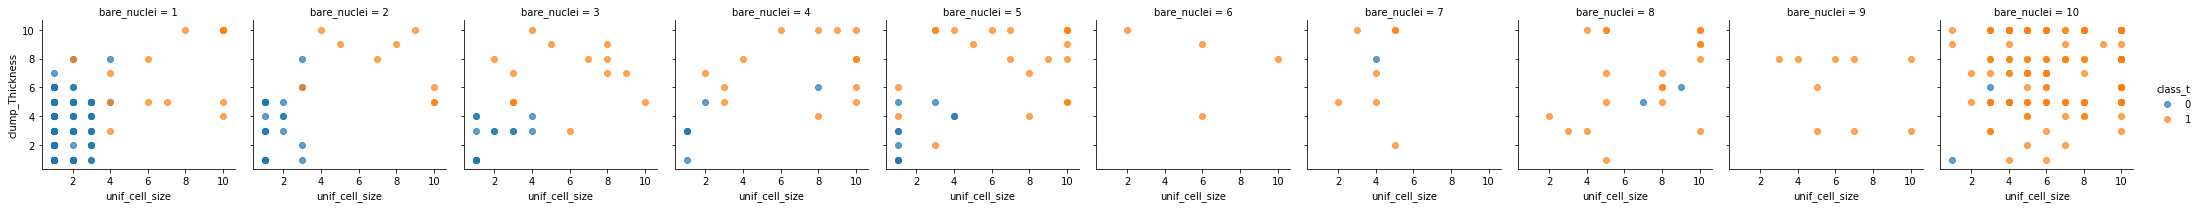

In [6]:
g = sns.FacetGrid(df, col="bare_nuclei", hue="class_t")
g.map(plt.scatter, "unif_cell_size", "clump_Thickness", alpha=.7)
g.add_legend();

## 3. Fiteando un modelo de regresión logística

Dividimos el target y la matriz de features

In [14]:
df.columns

Index(['ID', 'clump_Thickness', 'unif_cell_size', 'unif_cell_shape',
       'adhesion', 'epith_cell_Size', 'bare_nuclei', 'bland_chromatin ',
       'norm_nucleoli', 'mitoses', 'class_t'],
      dtype='object')

In [15]:
df = df.drop(['ID'], axis=1)
df.head()

,clump_Thickness,unif_cell_size,unif_cell_shape,adhesion,epith_cell_Size,bare_nuclei,bland_chromatin,norm_nucleoli,mitoses,class_t
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


In [16]:
X = df[['clump_Thickness', 'unif_cell_size', 'unif_cell_shape', 'adhesion',
       'epith_cell_Size', 'bare_nuclei', 'bland_chromatin ', 'norm_nucleoli',
       'mitoses']]
y = df['class_t']

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=12)

Vamos a dividir el dataset en set de entrenamiento y de testeo. 

Vamos a entrenar el modelo en el set de entrenamiento, aplicando validación cruzada para definir el mejor valor del parámetro de regularización C. Pueden aplicar también diferentes técnicas de regularización.

**Hint:** traten de usar el iterador [`KFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) del módulo `sklearn.model_selection`.

- Lo que devuelve el método `KFold` es un array de índices con las $k$ particiones entre train y test.

- Luego, pueden usar esos índices para hacer subsetting del dataframe

In [17]:
def search_coef(X_train,y_train,list_coef,CVL):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    lg_scores_result = []
    for coef in list_coef:
        model = linear_model.LogisticRegression(C=coef)
        # cross_val_scores devuelve resultados por cada particion
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=CVL)
        dict_row_score = {'score_medio':np.mean(cv_scores), 'score_std':np.std(cv_scores), 'C':coef}
        lg_scores_result.append(dict_row_score)
    return lg_scores_result

In [18]:
CVL = KFold(n_splits=5, shuffle=True)
c_values = np.linspace(0.00002, 0.1, 10)

result_coef = search_coef(X_train,y_train,c_values,CVL)
df_scores = pd.DataFrame(result_coef)
df_scores

,C,score_medio,score_std
0,0.000020,0.970664,0.008854
1,0.011129,0.972682,0.011280
2,0.022238,0.972701,0.016673
3,0.033347,0.972663,0.014368
4,0.044456,0.970760,0.022140
5,0.055564,0.972682,0.011280
6,0.066673,0.974643,0.009872
7,0.077782,0.972663,0.026533
8,0.088891,0.974567,0.023714
9,0.100000,0.970702,0.013758


In [19]:
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
df_scores.head()

,C,score_medio,score_std,limite_inferior,limite_superior
0,0.000020,0.970664,0.008854,0.961810,0.979518
1,0.011129,0.972682,0.011280,0.961402,0.983963
2,0.022238,0.972701,0.016673,0.956028,0.989374
3,0.033347,0.972663,0.014368,0.958295,0.987031
4,0.044456,0.970760,0.022140,0.948620,0.992899


* ¿Cuál es la performance de este modelo? ¿Cuáles son los mejores hiperparámetros?

In [20]:
df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]

,C,score_medio,score_std,limite_inferior,limite_superior
6,0.066673,0.974643,0.009872,0.964771,0.984515


In [21]:
best_c = df_scores.loc[df_scores.score_medio == df_scores.score_medio.max()]['C'][6]
best_c

0.06667333333333333

In [22]:
def model_linear_reg(X_train, X_test, y_train, y_test, coef):
    # standarizo
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # genero y entreno el modelo
    lg = linear_model.LogisticRegression(C=coef)
    lg.fit(X_train_scaled, y_train)
    # predicted
    y_pred_test = lg.predict(X_test_scaled)
    # accurancy
    accurancy = accuracy_score(y_test, y_pred_test)
    print("Accurancy:",accurancy)
    print("Intercept:",lg.intercept_)
    print("Coef:",lg.coef_)
    return lg

In [23]:
lg = model_linear_reg(X_train, X_test, y_train, y_test, best_c)

Accurancy: 0.9649122807017544
Intercept: [-0.54094748]
Coef: [[0.59728365 0.4402209  0.55493024 0.52806613 0.35478446 0.81823673
  0.57342587 0.50499961 0.39472515]]


### stats.model

In [24]:
import statsmodels.api as sm

In [25]:
def model_reg_log_stats(X_train,y_train):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train_stats = sm.add_constant(X_train_scaled)
    logit = sm.Logit(y_train, X_train_stats)
    result = logit.fit()
    print(result.summary2())
    return logit

In [26]:
model_reg_log_stats(X_train,y_train)

Optimization terminated successfully.
         Current function value: 0.064375
         Iterations 10
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.901      
Dependent Variable: class_t          AIC:              85.9204    
Date:               2019-07-17 21:36 BIC:              128.3037   
No. Observations:   512              Log-Likelihood:   -32.960    
Df Model:           9                LL-Null:          -331.37    
Df Residuals:       502              LLR p-value:      1.0096e-122
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     10.0000                                       
--------------------------------------------------------------------
             Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
--------------------------------------------------------------------
const       -0.6693     0.4157   -1.6101   0.1074   -1.4841   0.1455
x1           1.4688     0.5469    2.6855   0

## 4. Comparación con KNN

Con el mismo split entre train y test que generaron anteriormente, utilizar el conjunto de train para estimar un modelo de KNN con hiperparámetros óptimos y comparar la performance sobre datos no observados con respecto a la regresión logística. 